In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
from scipy.spatial import distance

cuda = torch.cuda.is_available()

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import random

In [4]:
from target_inference.target_ranking.ranking_targets import *
from target_inference import utils as utils
from target_inference.conclusion_target_modeling import *
from datasets import *
from target_embedding_utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/miladalshomary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Loading fasttext....


In [6]:
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [7]:
embedding_method='fasttext'

# Triplet network


In [8]:
top_k = 4
combination_of= 1
num_negs = 1
randomly_choose_k=False

In [9]:
ranking_model = RankedTargetModel('../models/idebate_ranking_model.pickle')
prem_essays_ranking_model = RankedTargetModel('../models/main_essays_ranking_model.pickle')
main_essays_ranking_model = RankedTargetModel('../models/premises_essays_ranking_model.pickle')

/home/miladalshomary/Development/thirdparty/anaconda/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [28]:
target_space_path= '../data/fasttext_embedded_only_conc_targets_space.pkl'

In [29]:
#cmv_train_data = json.load(open('../../data/cmv/train_filtered.json', 'r'))
main_essays_train_data = json.load(open('../data/student_essays_main_preprocessed/train_scored.json'))
prem_essays_train_data = json.load(open('../data/student_essays_premises_preprocessed/train_scored.json'))
idebate_train_data = json.load(open('../data/student_idebate_preprocessed/train_scored.json', 'r'))

idebate_val_data   = json.load(open('../data/student_idebate_preprocessed/dev_scored.json', 'r'))
main_essays_val_data   = json.load(open('../data/student_essays_main_preprocessed/dev_scored.json', 'r'))
prem_essays_val_data   = json.load(open('../data/student_essays_premises_preprocessed/dev_scored.json', 'r'))

idebate_test_data   = json.load(open('../data/student_idebate_preprocessed/test_scored.json', 'r'))

# Prepare the test function
target_space = pickle.load(open(target_space_path, 'rb'))

### Cleaning up the training data:

In [31]:
def filter_conc(conc):
    if len(conc['targets']) == 0:
        return False
#     if len(conc['targets'][0]['text'].split()) > 5:
#         return False
    if conc['targets'][0]['text'][0:-1].isupper():
        return False

    return True

In [32]:
idebate_train_data = list(filter(lambda x: filter_conc(x['conclusion']), idebate_train_data))
idebate_val_data   = list(filter(lambda x: filter_conc(x['conclusion']), idebate_val_data))
idebate_test_data  = list(filter(lambda x: filter_conc(x['conclusion']), idebate_test_data))

In [34]:
#train_data = cmv_train_data + idebate_train_data
train_data = idebate_train_data #  + prem_essays_train_data + main_essays_train_data

In [37]:
train_triplet_samples, train_p_avg, _ = prepare_data(train_data, target_space_file=target_space_path,
                                                                    embedding_method=embedding_method, triple_sampling=True, top_k=top_k,
                                                                    how_to_choose_k='rank', combination_of=combination_of, ranking_model=ranking_model, 
                                                                    num_negs=num_negs)

x0, x1, x2 = zip(*train_triplet_samples)
x0 = np.array(x0)
x1 = np.array(x1)
x2 = np.array(x2)

train_triplet_ds = TripletDataset(x0, x1, x2)

val_triplet_samples, val_p_avg, _  = prepare_data(idebate_val_data, target_space_file=target_space_path,
                                            embedding_method=embedding_method, triple_sampling=True, top_k=top_k, 
                                            how_to_choose_k='rank', combination_of=combination_of, ranking_model=ranking_model, 
                                             num_negs=num_negs)

x00, x11, x22 = zip(*val_triplet_samples)
x00 = np.array(x00)
x11 = np.array(x11)
x22 = np.array(x22)

val_triplet_ds = TripletDataset(x00, x11, x22)

In [38]:
idebate_test_data = prepare_test_data(idebate_test_data, embedding_method, top_k=top_k, how_to_choose_k='rank', 
                              ranking_model=ranking_model)

idebate_val_data = prepare_test_data(idebate_val_data, embedding_method, top_k=top_k, how_to_choose_k='rank', 
                              ranking_model=ranking_model)

main_essays_test_data = prepare_test_data(main_essays_val_data, embedding_method, top_k=top_k, how_to_choose_k='rank', 
                              ranking_model=main_essays_ranking_model)

prem_essays_test_data = prepare_test_data(main_essays_val_data, embedding_method, top_k=top_k, how_to_choose_k='rank', 
                              ranking_model=prem_essays_ranking_model)

In [39]:
len(train_triplet_ds)

4700

### Training a model:

In [40]:
# Set up the network and training parameters
from networks import TargetEmbeddingNet, SiameseNet, TripletNet, TargetCNNEmbeddingNet
from losses import ContrastiveLoss, TripletLoss

triplet_train_loader = torch.utils.data.DataLoader(train_triplet_ds, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(val_triplet_ds, batch_size=batch_size, shuffle=False, **kwargs)

In [63]:
test_fun = lambda model: test_model(model, idebate_val_data, target_space, combination_of=combination_of)

In [74]:
margin = 0.2
target_embedding_net = TargetEmbeddingNet(300, 100)
#avg_embedding_net = TargetEmbeddingNet(300, 300) # TargetCNNEmbeddingNet(emb_size=300, num_filters=10, output_dim=300, window_sizes=(3, 2, 1))
triple_model = TripletNet(target_embedding_net, target_embedding_net)
if cuda:
    triple_model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(triple_model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 300, gamma=0.5, last_epoch=-1)

In [75]:
n_epochs = 25
log_interval = 100
train_losses, val_losses, metrices = fit(triplet_train_loader, triplet_test_loader, triple_model, loss_fn, 
                                         optimizer, scheduler, n_epochs, cuda, log_interval, 
                                         callback_test=test_fun, keep_checkpoint_max=5, model_dir='./models/')

Train: [0/4700 (0%)]	Loss: 0.189684
Epoch: 1/25. Train set: Average loss: 0.1656
Epoch: 1/25. Validation set: Average loss: 0.1419
Train: [0/4700 (0%)]	Loss: 0.118935
Epoch: 2/25. Train set: Average loss: 0.0977
Epoch: 2/25. Validation set: Average loss: 0.1152
Train: [0/4700 (0%)]	Loss: 0.062573
Finshed Mapping...
Optimistic Model Acc:  [0.19, 0.11, 0.11]
Optimistic Baseline Acc:  [0.22, 0.14, 0.14]
Optimistic Model BLEU:  8.465
Optimistic Baseline BLEU:  7.621
Optimistic Model METEOR:  0.125
Optimistic Baseline METEOR:  0.167
Epoch: 3/25. Train set: Average loss: 0.0648
Epoch: 3/25. Validation set: Average loss: 0.1039
Train: [0/4700 (0%)]	Loss: 0.051232
Epoch: 4/25. Train set: Average loss: 0.0498
Epoch: 4/25. Validation set: Average loss: 0.0933
Train: [0/4700 (0%)]	Loss: 0.049111
Epoch: 5/25. Train set: Average loss: 0.0390
Epoch: 5/25. Validation set: Average loss: 0.0939
Train: [0/4700 (0%)]	Loss: 0.030928
Finshed Mapping...
Optimistic Model Acc:  [0.18, 0.09, 0.09]
Optimistic B

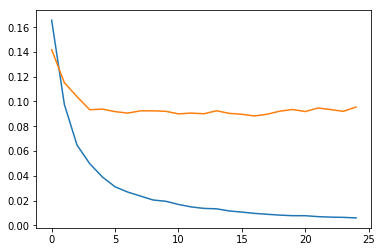

In [76]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

### Testing the model:

In [77]:
def perform_evaluation(model, test_data, target_space, test_scenario='optimistic'):
    baseline_acc, model_acc, baseline_meteor, baseline_bleu,\
    model_meteor, model_bleu, model_preds, baseline_preds = test_model(model, test_data, target_space, 
                                                            test_scenario=test_scenario,
                                                            combination_of=combination_of)
    print('Optimistic Model Acc: ', model_acc)
    print('Optimistic Baseline Acc: ', baseline_acc)
    print('Optimistic Model BLEU: ', model_bleu)
    print('Optimistic Baseline BLEU: ', baseline_bleu)
    print('Optimistic Model METEOR: ', model_meteor)
    print('Optimistic Baseline METEOR: ', baseline_meteor)

In [78]:
#Test only the targets we learned on..
#model_acc, baseline_acc, model_preds, baseline_preds = test_model(triple_model, test_data, new_target_space)

In [79]:
perform_evaluation(triple_model, idebate_test_data, target_space, test_scenario='optimistic')

Finshed Mapping...
Optimistic Model Acc:  [0.24, 0.14, 0.14]
Optimistic Baseline Acc:  [0.31, 0.19, 0.18]
Optimistic Model BLEU:  8.652
Optimistic Baseline BLEU:  8.213
Optimistic Model METEOR:  0.119
Optimistic Baseline METEOR:  0.166


In [80]:
perform_evaluation(triple_model, idebate_test_data, target_space, test_scenario='pessimistic')

Finshed Mapping...
Optimistic Model Acc:  [0.23, 0.12, 0.12]
Optimistic Baseline Acc:  [0.31, 0.19, 0.18]
Optimistic Model BLEU:  6.04
Optimistic Baseline BLEU:  7.898
Optimistic Model METEOR:  0.102
Optimistic Baseline METEOR:  0.164


In [57]:
model_fn = lambda x: triple_model.get_target_embedding(x).detach().numpy()

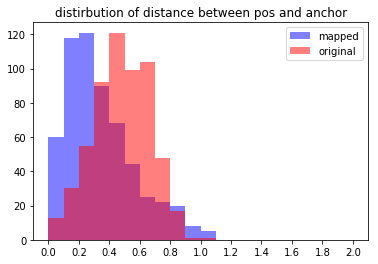

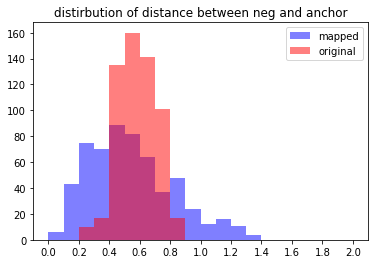

In [58]:
%matplotlib inline

show_distance_dist(model_fn, val_triplet_ds)

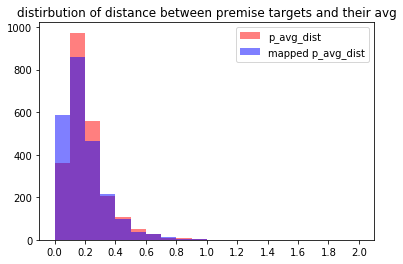

In [37]:
p_avg_dist = [distance.cosine(x[0], x[1]) for x in val_p_avg]
mapped_p_avg_dist = [distance.cosine(triple_model.get_avg_embedding(torch.from_numpy(x[0])).detach().numpy(), 
                                     triple_model.get_target_embedding(torch.from_numpy(x[1])).detach().numpy()) for x in val_p_avg]

#p_avg_dist = [2 if np.isnan(x) else x for x in p_avg_dist]

plt.hist(p_avg_dist, alpha = 0.5, color='red', label='p_avg_dist', bins=np.arange(0,2.1, 0.1))
plt.hist(mapped_p_avg_dist, alpha = 0.5, color='blue', label='mapped p_avg_dist', bins=np.arange(0,2.1, 0.1))
plt.title('distirbution of distance between premise targets and their avg')
plt.xticks(np.arange(0, 2.1, 0.2))
plt.legend()
plt.show()

In [26]:
torch.save(triple_model.state_dict(), 'triplet-model.pth')